# HW 2

In [2]:
import pandas as pd
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from io import BytesIO

## 1. Phase trainsition in PCA 'spike' model

In [12]:
#  (d) Confirm result
n = 1000
p = 50
gamma = p / n
sigma = 1
lambda_0s = [0.1, 0.2, 0.5, 1 ,2 ,4]  # Vary this to see different effects
u = np.zeros(p)
u[0] = 1

for lambda_0 in lambda_0s:
    SNR = lambda_0 / sigma**2

    X = np.random.normal(0, sigma, (n, p))
    X[:, 0] = np.random.normal(0, np.sqrt(lambda_0 + 1), n)
    S_n = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eigh(S_n)
    idx = np.argmax(eigenvalues)
    v = eigenvectors[:, idx]
    lambda_max = eigenvalues[idx]

    corrrelation_uv = np.dot(u, v)**2
    corrrelation_uv_compare = (1-(p/n)/SNR**2)/(1+(p/n)/SNR)

    if SNR > np.sqrt(p/n):
        print("SNR > sqrt(p/n)")
        lambda_max_compare = (1+lambda_0)*(1+gamma/lambda_0)
    else:
        print("SNR <= sqrt(p/n)")
        lambda_max_compare = (1 + np.sqrt(gamma))**2
        corrrelation_uv_compare = 0

        # confirm lambda_max
    print("Lambda max:", round(lambda_max,3))
    print("Lambda max by MP law:", round(lambda_max_compare, 3))

    # confirm v
    print("Corresponding eigenvector correlation:", round(corrrelation_uv, 3))
    print("Corresponding eigenvector correlation by MP law:", round(corrrelation_uv_compare, 3))

SNR <= sqrt(p/n)
Lambda max: 1.495
Lambda max by MP law: 1.497
Corresponding eigenvector correlation: 0.001
Corresponding eigenvector correlation by MP law: 0
SNR <= sqrt(p/n)
Lambda max: 1.459
Lambda max by MP law: 1.497
Corresponding eigenvector correlation: 0.35
Corresponding eigenvector correlation by MP law: 0
SNR > sqrt(p/n)
Lambda max: 1.577
Lambda max by MP law: 1.65
Corresponding eigenvector correlation: 0.656
Corresponding eigenvector correlation by MP law: 0.727
SNR > sqrt(p/n)
Lambda max: 2.05
Lambda max by MP law: 2.1
Corresponding eigenvector correlation: 0.902
Corresponding eigenvector correlation by MP law: 0.905
SNR > sqrt(p/n)
Lambda max: 3.111
Lambda max by MP law: 3.075
Corresponding eigenvector correlation: 0.965
Corresponding eigenvector correlation by MP law: 0.963
SNR > sqrt(p/n)
Lambda max: 5.208
Lambda max by MP law: 5.062
Corresponding eigenvector correlation: 0.98
Corresponding eigenvector correlation by MP law: 0.985


According to the results, we can see that the lambda_max and the corresponding eigenvector correlation are consistent with the theoretical results. When SNR > sqrt(p/n), the lambda_max is consistent with the theoretical result. When SNR <= sqrt(p/n), the corresponding eigenvector correlation do not match the theoretical result well.

## 2. Exploring S & P stock price

In [13]:
# Set up data matrix
url = "https://github.com/yao-lab/yao-lab.github.io/raw/master/data/snp452-data.mat"
response = requests.get(url)
data = scipy.io.loadmat(BytesIO(response.content))
print(data.keys())

stock = data['stock']
X = data['X']
print(X.shape)

dict_keys(['__header__', '__version__', '__globals__', 'stock', 'X'])
(1258, 452)


In [14]:
# (a) Logarithimic prices
Y = np.log(X)
print('Price of first stock at first time point:', X[0, 0])
print('Logarithmic price of first stock at first time point:', Y[0, 0])

Price of first stock at first time point: 126.75
Logarithmic price of first stock at first time point: 4.842216642471293


In [15]:
# (b) Logarithmic price jumps
diff_Y_matrix = np.diff(Y, axis=0)
print(diff_Y_matrix.shape)
print('Logarithmic price of first stock at first 3 point:', Y[0:3, 0])
print('Logarithmic price jump of first stock at first 3 day point:', diff_Y_matrix[0:2, 0])

(1257, 452)
Logarithmic price of first stock at first 3 point: [4.84221664 4.83842247 4.84568203]
Logarithmic price jump of first stock at first 3 day point: [-0.00379417  0.00725956]


In [24]:
# (c) Normalize covariance matrix
cov_matrix = diff_Y_matrix.T.dot(diff_Y_matrix) / diff_Y_matrix.shape[0]
print(cov_matrix.shape)

(452, 452)


In [25]:
# (d) Eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
# descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
print('top 5 eigenvalues:', eigenvalues[:5])

top 5 eigenvalues: [0.03834524 0.00892081 0.00759199 0.00504735 0.00394434]


C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_25244\2239993582.py:56: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, dim)


(0.7366192741127062, 452.0)

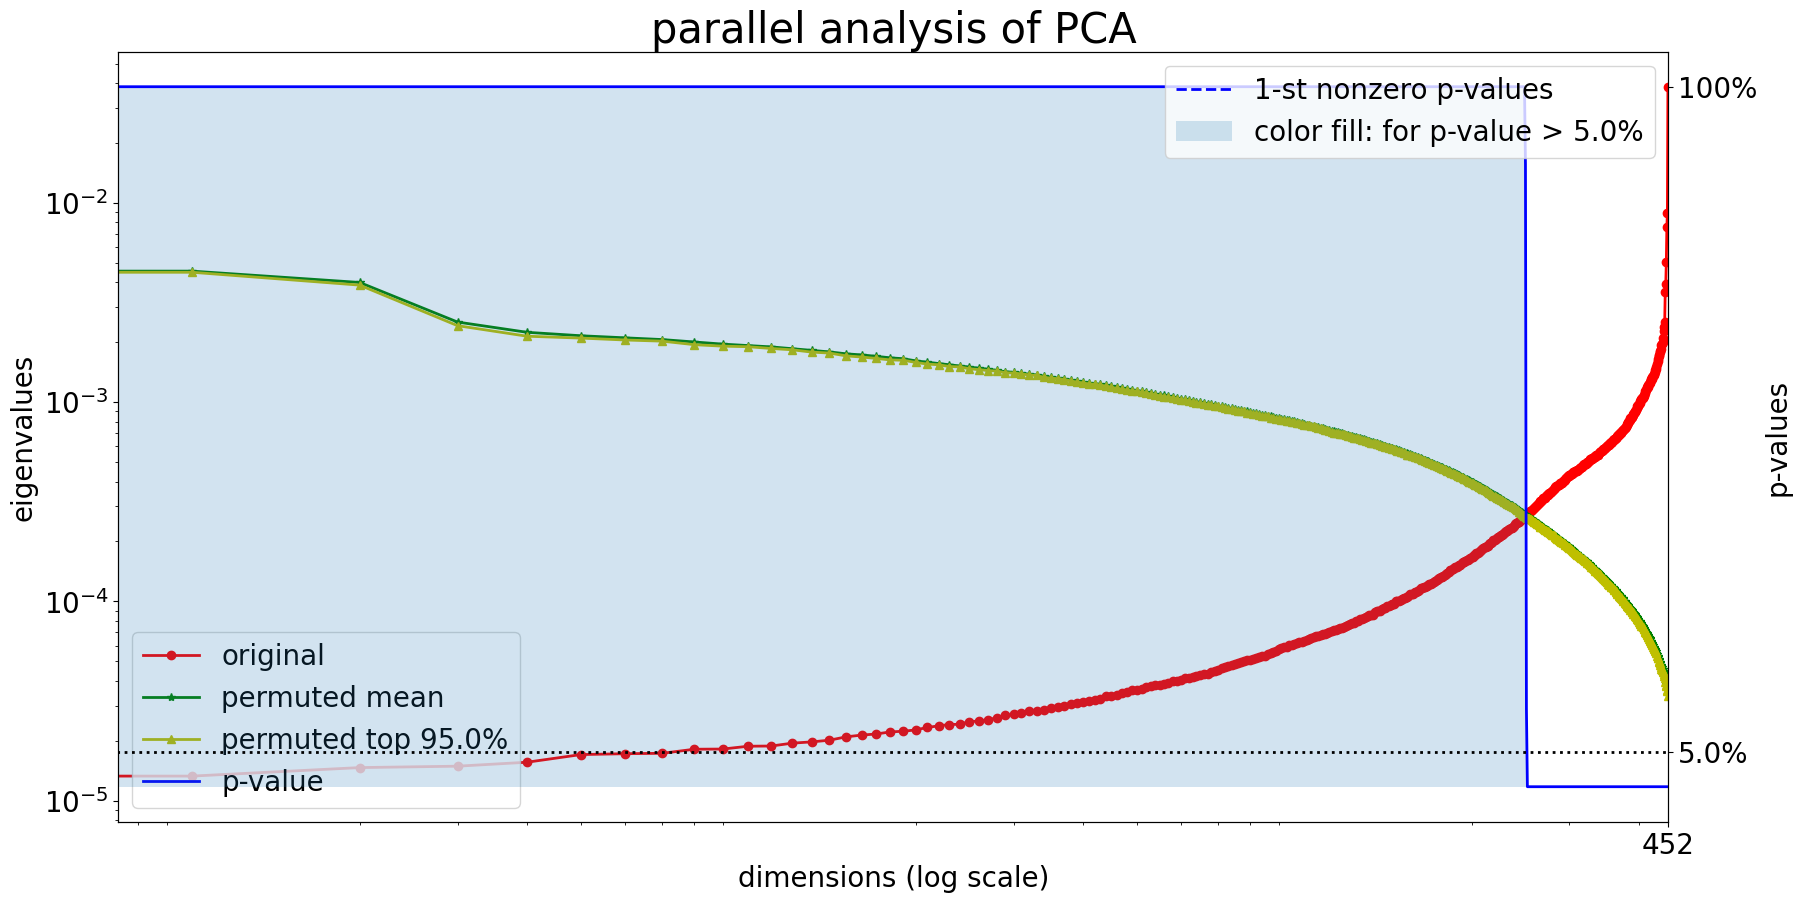

In [36]:
# (e) Horn's parallel analysis
n_perm = 9
perc = 0.95
n, dim = diff_Y_matrix.shape

evals = eigenvalues[::-1]
evecs = eigenvectors[:, ::-1]

diff_Y_matrix_cp = diff_Y_matrix.copy()
evals_perm = np.zeros([n_perm, dim])

for i in range(n_perm):
    for j in range(1, dim):
        np.random.shuffle(diff_Y_matrix_cp[:, j])
    Cov_perm = np.dot(diff_Y_matrix_cp.T, diff_Y_matrix_cp)/n
    evals_perm[i] = np.linalg.eigvalsh(Cov_perm)[::-1]

evals0 = np.mean(evals_perm, axis = 0)
evals_perm = np.sort(evals_perm, axis = 0)[::-1]
evals_perc = evals_perm[int(np.floor(perc * n_perm))]
pvals = np.mean((evals_perm > evals).astype(float), axis = 0)

# index of the first nonzero p-values
for j in range(dim):
    if pvals[j] > 0:
        pv1 = j
        break

plt.figure(figsize = (20, 10))
ax = plt.subplot(111)
ax.loglog(evals, 'r-o', linewidth = 2, label = r'original')
ax.loglog(evals0, 'g-*', linewidth = 2, label = r'permuted mean')
ax.loglog(evals_perc, 'y-^', linewidth = 2, label = r'permuted top %s%s'%(perc*100, '%'))
ax.plot(np.nan, 'b', linewidth = 2, label = r'p-value') # agent
ax.set_xticks([pv1, dim])
ax.set_xticklabels([pv1, dim])
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
ax.set_xlabel('dimensions (log scale)', fontsize = 20)
ax.set_ylabel('eigenvalues', fontsize = 20)
ax.legend(loc = 'lower left', fontsize = 20)

ax1 = ax.twinx()
ax1.plot(pvals, 'b', linewidth = 2)
ax1.vlines(pv1, 0, 1, 'b', 'dashed', linewidth = 2, label = r'1-st nonzero p-values')
ax1.hlines(1-perc, pv1, dim, 'k', 'dotted', linewidth = 2)
ax1.fill_between(np.arange(dim), np.ones(dim), where = (pvals > 1-perc),
                alpha = 0.2, label = r'color fill: for p-value > %s%s'%(100-perc*100, '%'))
ax1.tick_params(axis='y', labelsize = 20)
ax1.set_yticks([1-perc, 1])
ax1.set_yticklabels(['%s%s'%(100-100*perc, '%'), '%s%s'%(100, '%')])
ax1.set_ylabel('p-values', fontsize = 20)
ax1.legend(loc = 'upper right', fontsize = 20)

plt.title('parallel analysis of PCA', fontsize = 30)
plt.xlim(0, dim)

component from the actual data that is stronger (has a larger eigenvalue) than the corresponding value derived from random data is meaningful and should be retained.

# 3. Finite rank perturbation of random symmetric matrices

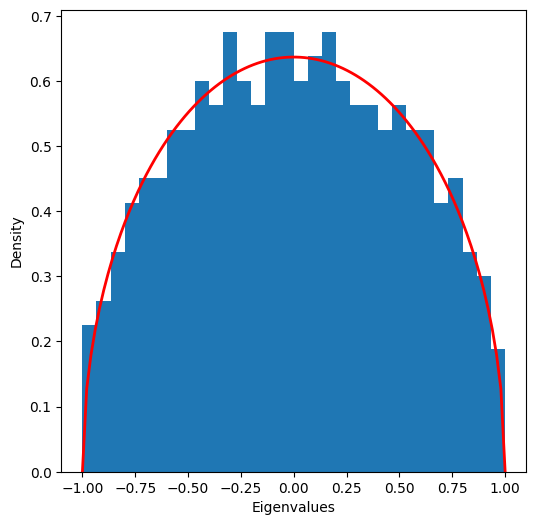

In [60]:
# (a) Confirm wigerner's semi-circle law
# Create a random symmetric matrix
n = 400
W = np.zeros((n, n))
for i in range(n):
    for j in range(i, n):
        W[i, j] = np.random.normal(0, 1/(4*n))
        W[j, i] = W[i, j]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
egvals, egvecs = np.linalg.eigh(W)

normalized_egvals = egvals/np.max(abs(egvals))

ax.hist(normalized_egvals, density=True, bins=30)

t = np.linspace(-1, 1, 100)
y = 2*np.sqrt(1-t**2)/(np.pi)
ax.plot(t, y, 'r', linewidth=2)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Density')

plt.show()